In [1]:
import numpy as np
import pandas as pd
import glob
import time
import cv2
import h5py
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
%matplotlib inline

In [3]:
# data directory, which stores the raw X-ray images from the first 3 compressed files 
# (images_001.tar.gz, images_0012.tar.gz, images_003.tar.gz)
data_dir = 'images/'

# The classes are 14 common thoracic pathologies (See 'https://nihcc.app.box.com/v/ChestXray-NIHCC/file/220660789610'), 
# and 'no finding' diagnosis. Thus, there are total 15 classes.
classes  = ['No Finding', 'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 
           'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass','Hernia']

# Load Data information
data_info = pd.read_csv('Data_Entry_2017.csv')

# Select rows with used dataset (on the first 3 compressed files are used)
img_handles = glob.glob(data_dir + '*.png')
img_names   = [handle.split('/')[1] for handle in img_handles]
img_labels  = data_info[['Image Index','Finding Labels']][data_info['Image Index'].isin(img_names)]

# Select those imgs with labels in the common diagnosis
img_labels_select = img_labels[['Image Index','Finding Labels']][img_labels['Finding Labels'].isin(classes)]

In [4]:
img_labels_select_count = pd.DataFrame(img_labels_select['Finding Labels'].value_counts()).reset_index()
img_labels_select_count.columns = ['Labels', 'Count']

### Check out image size for each classes

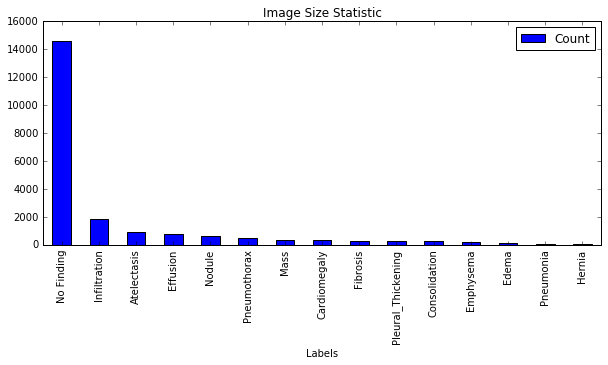

In [5]:
img_labels_select_count.plot.bar(x=img_labels_select_count['Labels'],figsize=(10, 4), title = 'Image Size Statistic')

The plot above shows that the 'No Finding' diagnosis dominates the dataset. 

There is a class imbalance issue. Usualy, downsampling the 'No Finding' class can help.

### Downsample the images labeled as 'No Finding', to balance the image size to some extent

In [6]:
# Picked up the image labels with 'No Finding' Labels
img_labels_NoFinding = img_labels_select[img_labels_select['Finding Labels'] == 'No Finding']
# The other 14 labels
img_labels_no_NoFinding = img_labels_select[~img_labels_select.index.isin(img_labels_NoFinding.index)]

# Randomly sample 10% of image labels with 'No Finding' Labels
img_labels_NoFinding_sampled = img_labels_NoFinding.sample(frac=0.1)

# Concatenate together
img_lables_select_balanced = pd.concat([img_labels_NoFinding_sampled,img_labels_no_NoFinding])

In [7]:
img_labels_select_balanced_count = pd.DataFrame(img_lables_select_balanced['Finding Labels'].value_counts()).reset_index()
img_labels_select_balanced_count.columns = ['Labels', 'Count']

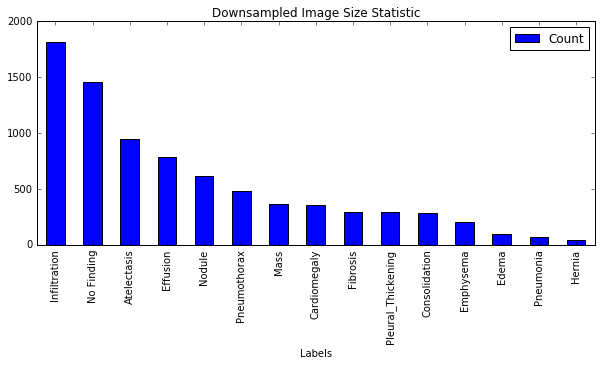

In [8]:
img_labels_select_balanced_count.plot.bar(x=img_labels_select_balanced_count['Labels'],figsize=(10, 4), 
                                          title = 'Downsampled Image Size Statistic')

### Preprocessing first 200 images

In [9]:
def load_preprocess(img_id, labels, num, new_img_size):
    '''Load X-ray images by patient, and resample and normalize them,
    returns a list of 2D images (in form of 2D np.array and cooresponding labels.
    
    *parameters*: 
    img_id: image index
    labels: all labels for all imgs
    new_img_size: the image size after sampling'''
    
    path_to_img = data_dir + img_id

    PT_image = cv2.imread(path_to_img)

    # use opencv to resise the 1024 by 1024 imgs to 224 by 224, or whatever new_img_size
    PT_resized_image = cv2.resize(PT_image, new_img_size)

    label = labels[num]
    label_encoded = LE.transform([label])
    return PT_resized_image, label_encoded

In [10]:
img_id = img_labels_select['Image Index'].tolist()
labels = img_labels_select['Finding Labels'].tolist()
LE = LabelEncoder()
LE.fit(labels)

# Preprocessing settings
new_img_size = (224, 224)

t0 = time.time()
Resampled_data = []
Encoded_labels = []
patients_retrieval = []
print '----------------------------------------------------------------------'
for num, img in enumerate(img_id[:200]):
    # print 'Preprocessing image %d out of %d labeled images.' %(num+1, len(img_id))
    preprocessed_img, encoded_label = load_preprocess(img, labels, num, new_img_size)
    Resampled_data.append(preprocessed_img)
    Encoded_labels.append(encoded_label)

t1 = time.time()
t  = t1 - t0

print 'Preprocessing Completed!'
print 'The preprocessing process took %.2f mins.' %(round(t/60., 2))
print '----------------------------------------------------------------------'

print 'Saving Preprocessed imgs and corresponding labels into HDF5 format...'
# Save preprocessed data as hdf5 format
with h5py.File('Resampled_data_samples.h5', 'w') as w_hf:
    w_hf.create_dataset("preprocessed_data",  data=Resampled_data)
    w_hf.create_dataset('label', data=Encoded_labels)
print 'Saving Completed!'
print '----------------------------------------------------------------------' 

----------------------------------------------------------------------
Preprocessing Completed!
The preprocessing process took 0.14 mins.
----------------------------------------------------------------------
Saving Preprocessed imgs and corresponding labels into HDF5 format...
Saving Completed!
----------------------------------------------------------------------


### Show preprocessed data, peek what X-ray image looks like for each diagnosis

In [11]:
# Load H5 file
hdf5_path_img = 'Resampled_data_samples.h5'
with h5py.File(hdf5_path_img,'r') as f:
    X = f["preprocessed_data"][:]
    y = f["label"][:].ravel()

In [12]:
y_df = pd.DataFrame(y)

In [13]:
y_df_unique = y_df.drop_duplicates()

In [14]:
y_df_unique_idx = y_df_unique.index.tolist()

In [15]:
y_df_unique['Text Label'] = LE.inverse_transform(y_df_unique)

/Users/JundongQiao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [16]:
y_df_unique

,0,Text Label
0,1,Cardiomegaly
1,10,No Finding
2,7,Hernia
15,8,Infiltration
20,11,Nodule
21,5,Emphysema
23,4,Effusion
29,0,Atelectasis
33,12,Pleural_Thickening
37,14,Pneumothorax


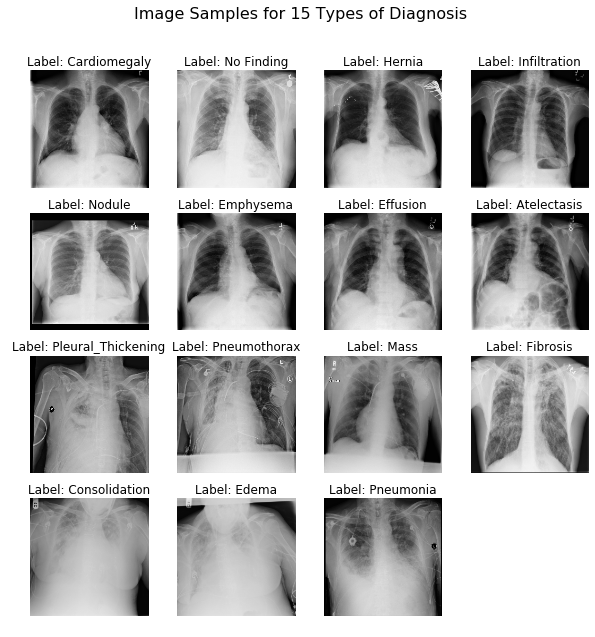

In [17]:
# plot the 15 sample images
fig = plt.figure(figsize=(10,10))
plt.suptitle('Image Samples for 15 Types of Diagnosis', fontsize=16)
fig.subplots_adjust(hspace=0.1, wspace=0.25)
for num, i in enumerate(y_df_unique_idx):
    im = fig.add_subplot(4,4, num+1)
    im.set_title('Label: %s' %(LE.inverse_transform(y)[i]), fontsize=12)
    im.imshow(X[i, :,:])
    im.axis('off')
plt.show()

Intuitively, there are some non-trivial differences between images of different diagnosis. 

It is believed that deep learning can learn the underlying features and make decent computer-aided diagnosis.